# US Presidents EDA (2025)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
root_path = Path().resolve().parent # Absolute path to the parent directory of this notebook
sys.path.append(str(root_path))

from us_presidents import fetch

# Fetch the presidents dataset (loading a stable snapshot)
df = fetch()
df.head()

,name,birth,death,term_start,term_end,party,election,vice_president
number,,,,,,,,
1,George Washington,1732,1799,1789-04-30,1797-03-04,[Unaffiliated],"[1788, 1792]",[John Adams]
2,John Adams,1735,1826,1797-03-04,1801-03-04,[Federalist],[1796],[Thomas Jefferson]
3,Thomas Jefferson,1743,1826,1801-03-04,1809-03-04,[Democratic-Republican],"[1800, 1804]",[Aaron Burr George Clinton]
4,James Madison,1751,1836,1809-03-04,1817-03-04,[Democratic-Republican],"[1808, 1812]","[George Clinton, Vacant after April 20, 1812, ..."
5,James Monroe,1758,1831,1817-03-04,1825-03-04,[Democratic-Republican],"[1816, 1820]",[Daniel D. Tompkins]


In [2]:
# Let's locate all the presidents who are still living
living_presidents = df.loc[df['death'].isna()]

# Sort by presidential number in descending order
living_presidents = living_presidents.sort_index(ascending=False)

# Remove duplicate names (same person), keep the most recent account
living_presidents = living_presidents.drop_duplicates(subset='name', keep='first')

print(f'Number of presidents still alive: {living_presidents.shape[0]}')
print()

for number, row in living_presidents.iterrows():
	name = row['name']
	birth_year = row['birth']
	print(f'{number:2} {name:15} (b. {birth_year})')

Number of presidents still alive: 5

47 Donald Trump    (b. 1946)
46 Joe Biden       (b. 1942)
44 Barack Obama    (b. 1961)
43 George W. Bush  (b. 1946)
42 Bill Clinton    (b. 1946)


## 👴 Age During Inauguration Year

Now, let's investigate how old each U.S. president was when they took office.

We will explore:

- What the average age at inauguration is

- Who was the oldest and youngest president to assume office

- How has this changed over time

- Does party affiliation reveal any trends

In [3]:
# Extract the year from term_start
df['term_start_year'] = df['term_start'].dt.year

# Compute president's age (as of that year)
df['inauguration_age'] = df['term_start_year'] - df['birth']

inaugural_cols = ['name', 'birth', 'term_start_year', 'inauguration_age', 'party']

df[inaugural_cols].tail()

,name,birth,term_start_year,inauguration_age,party
number,,,,,
43,George W. Bush,1946,2001,55,[Republican]
44,Barack Obama,1961,2009,48,[Democratic]
45,Donald Trump,1946,2017,71,[Republican]
46,Joe Biden,1942,2021,79,[Democratic]
47,Donald Trump,1946,2025,79,[Republican]


In [4]:
# Average
avg_age = df['inauguration_age'].mean()
print(f'Average age during inauguration year: {avg_age:.2f} years')

Average age during inauguration year: 56.74 years


In [5]:
# Youngest
min_age = df['inauguration_age'].min()
youngest_presidents = df[df['inauguration_age'] == min_age]
youngest_presidents[inaugural_cols]

,name,birth,term_start_year,inauguration_age,party
number,,,,,
26,Theodore Roosevelt,1858,1901,43,[Republican]


In [6]:
# Oldest
max_age = df['inauguration_age'].max()
oldest_presidents = df[df['inauguration_age'] == max_age]
oldest_presidents[inaugural_cols]

,name,birth,term_start_year,inauguration_age,party
number,,,,,
46,Joe Biden,1942,2021,79,[Democratic]
47,Donald Trump,1946,2025,79,[Republican]


We have found the __youngest__ president to be __Theodore Roosevelt (1901)__, at 43 years old.

And both __Joe Biden (2021)__ and __Donald Trump (2025)__ are tied for the __oldest__ presidents, who turned 79 during their inauguration year.

Interestingly, the oldest presidents seem to be more recent. Perhaps this is a trend.

## 📈 Age Trends

In [7]:
# Let's sort the data by inauguration age in descending order to gain insights
df_sorted_by_age = df.sort_values(by=['inauguration_age', 'term_start_year'], ascending=[False, False])
df_sorted_by_age[inaugural_cols].head(10)

,name,birth,term_start_year,inauguration_age,party
number,,,,,
47,Donald Trump,1946,2025,79,[Republican]
46,Joe Biden,1942,2021,79,[Democratic]
45,Donald Trump,1946,2017,71,[Republican]
40,Ronald Reagan,1911,1981,70,[Republican]
9,William Henry Harrison,1773,1841,68,[Whig]
15,James Buchanan,1791,1857,66,[Democratic]
41,George H. W. Bush,1924,1989,65,[Republican]
12,Zachary Taylor,1784,1849,65,[Whig]
34,Dwight D. Eisenhower,1890,1953,63,[Republican]


After a brief look, there is no apparent correlation.

We have old presidents (> 65 y/o) dating back to the 1800s as well as the 21st century.

However, let's visualize the data for more clarity!

In [8]:
# Color by party
def extract_main_party(parties):
	''' Take the president's first affiliated party as their main and color.

		If the president became either Republican or Democratic in their second term, 
		override that as their main.
	'''
	# parties is a list, e.g. ['Democratic-Republican', 'SomethingElse']
	for p in parties:
		if p == 'Democratic':
			return p
	for p in parties:
		if p == 'Republican':
			return p
	return parties[0] if parties else pd.NA

df['main_party'] = df['party'].apply(extract_main_party)

Let's view all unique __main parties__ and assign a different color to each one.

We will also show the number of rows belonging to each main party.

In [9]:
party_counts = df['main_party'].value_counts()

for party, count in party_counts.items():
	print(f'({count}) {party}')

(20) Republican
(17) Democratic
(4) Democratic-Republican
(4) Whig
(1) Unaffiliated
(1) Federalist


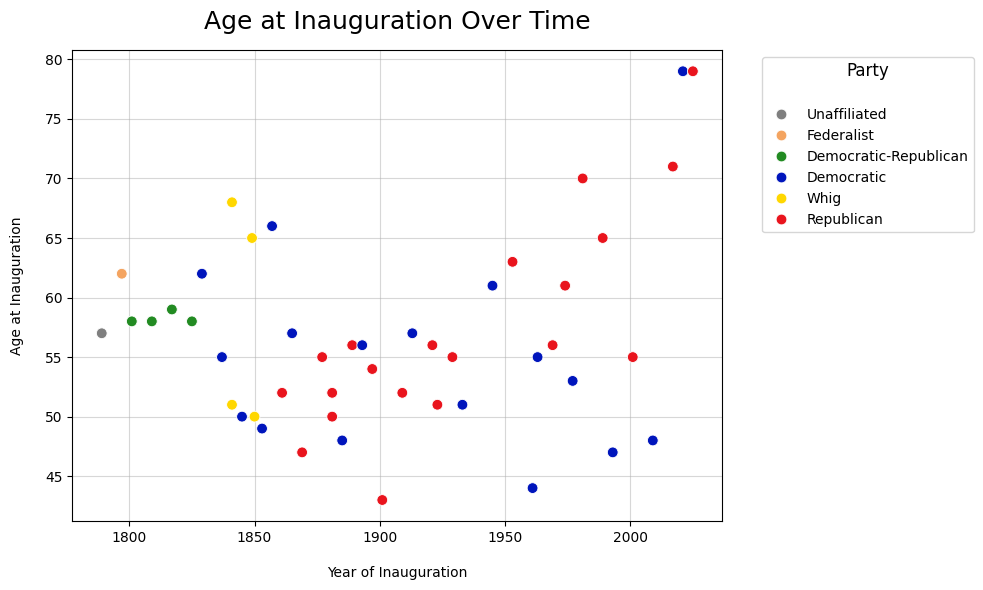

In [10]:
# Map parties to colors
party_colors = {
	'Democratic': '#0015BC',
	'Republican': '#E9141D',
	'Democratic-Republican': '#228B22',
	'Whig': '#FFD700',
	'Federalist': "#F4A460",
	'Unaffiliated': '#7F7F7F'
}

# Scatter plot creation
plt.figure(figsize=(10, 6))
sns.scatterplot(
	data=df,
	x='term_start_year',
	y='inauguration_age',
	hue='main_party',
	palette=party_colors,
	s=60,
	zorder=2 # Draw markers on top
)

plt.title('Age at Inauguration Over Time', pad=15, fontsize=18)
plt.xlabel('Year of Inauguration', labelpad=15)
plt.ylabel('Age at Inauguration', labelpad=15)
plt.grid(True, alpha=0.5)
plt.legend(title='Party\n', title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 🎯 Age Trends By Politcal Party

Our scatter plot shows that __inauguration age__ has ranged widely across U.S. history, with presidents taking office between their mid-40s and mid-60s—a spread of about 30 years.

While there are no obvious trends in age as a whole, an interesting divergence appears __after World War II__.

Starting around __1945–1950__, there seems to be a trend:

- __Republican presidents (red)__ generally became _older_ at the time of inauguration.

- __Democratic presidents (blue)__ trended slightly _younger_.

This post-war split might reflect different political strategies, cultural shifts or generational appeals within each party. It could also coincide with the emergence of the U.S. as a global superpower—a time when leadership experience may have become more prized (or differently interpreted) across party lines.

But we need more than observation—let's investigate whether the differences in average age by party __pre- vs. post-WWII__ are statistically meaningful.



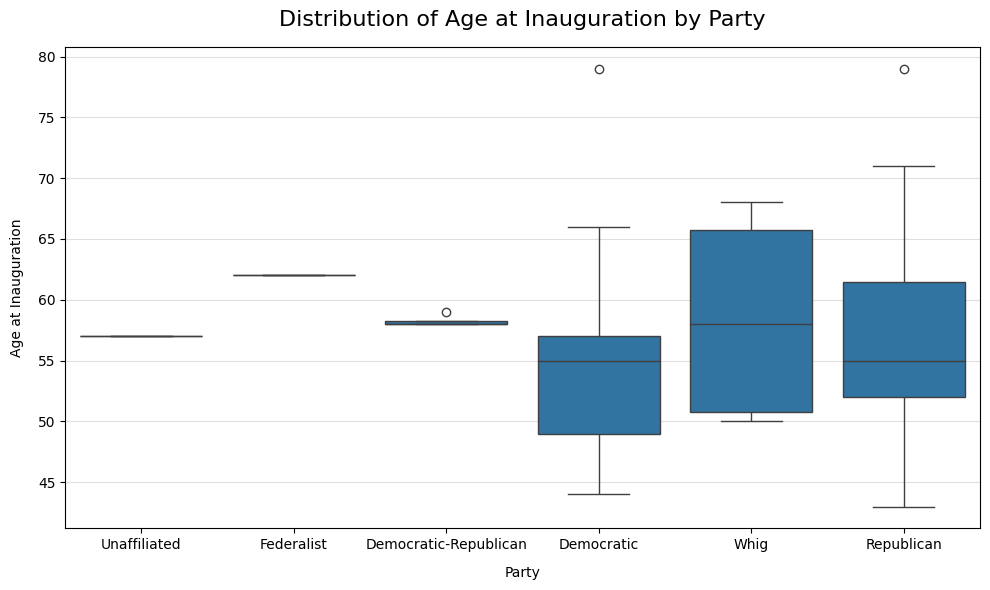

In [11]:
# First, we make Box Plots (across all time)
plt.figure(figsize=(10, 6))
sns.boxplot(
	data=df,
	x='main_party',
	y='inauguration_age'
)

plt.title('Distribution of Age at Inauguration by Party', fontsize=16, pad=15)
plt.xlabel('Party', labelpad=10)
plt.ylabel('Age at Inauguration', labelpad=10)
plt.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


We can broadly observe the democratic data are skewed towards younger ages, and the republican data are skewed towards older ages.

Now, let's continue our pre- vs post-WWII investigation.

In [12]:
# Let's define the WWII boundary -- we'll split by year (1945)
df['wwii_era'] = df['term_start_year'].apply(lambda year: 'Pre-WWII' if year < 1945 else 'Post-WWII')

# We make this categorical data and impose an ordering
df['wwii_era'] = pd.Categorical(
	df['wwii_era'],
	categories=['Pre-WWII', 'Post-WWII'],
	ordered=True
)

# Filter to only Democratic and Republican parties
df_filtered = df[df['main_party'].isin(['Democratic', 'Republican'])].copy()

# Next, we'll group by main_age and wwii_era, and compute the mean ages
age_summary = (
	df_filtered
	.groupby(['main_party', 'wwii_era'], observed=True)['inauguration_age']
	.agg(['count', 'mean', 'std'])
	.round(2)
	.sort_index(level=[0, 1])
)

age_summary

count   mean   std
main_party wwii_era                     
Democratic Pre-WWII      10   55.1  5.82
           Post-WWII      7  55.29  11.9
Republican Pre-WWII      12  51.92  3.87
           Post-WWII      8   65.0  8.09

We can see that there were roughly equal numbers of Democratic and Republican presidents in both the pre- and post-WWII eras—so no group is severely overrepresented.

The average age for Democratic presidents remained almost unchanged across the two eras (around 55 years). In contrast, Republican presidents saw a sharp increase in average inauguration age after WWII—jumping from about 52 to 65 years, a notable shift of over 10 years.

Additionally, the spread (standard deviation) of ages increased for both parties in the post-WWII era. This suggests that presidential age became more variable in the modern era, possibly reflecting shifts in party strategy or evolving cultural attitudes.

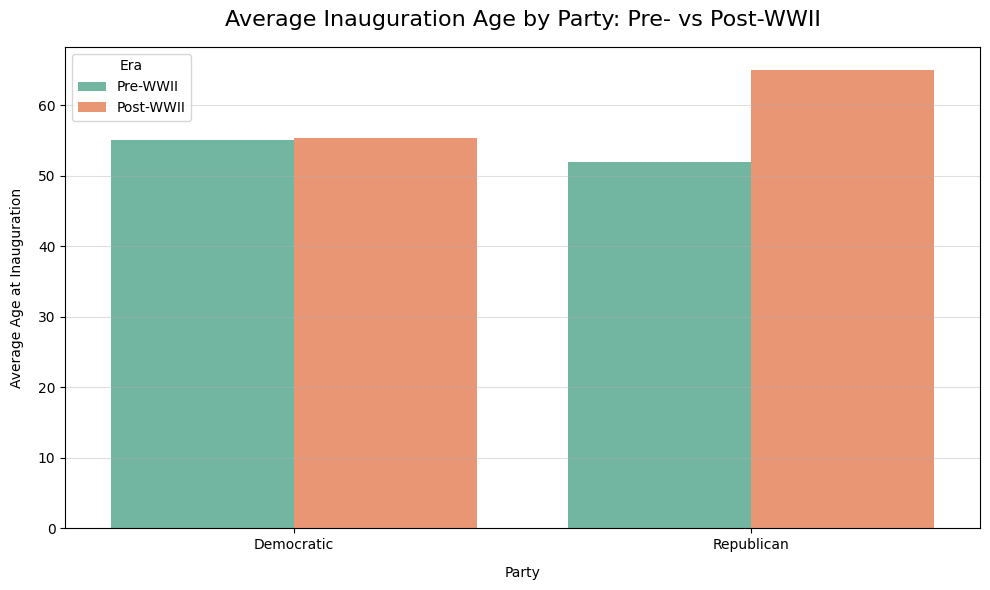

In [13]:
# Now we can visualize the difference
plt.figure(figsize=(10, 6))
sns.barplot(
	data=df_filtered,
	x='main_party',
	y='inauguration_age',
	hue='wwii_era',
	palette='Set2',
	errorbar=None
)

plt.title('Average Inauguration Age by Party: Pre- vs Post-WWII', fontsize=16, pad=15)
plt.xlabel('Party', labelpad=10)
plt.ylabel('Average Age at Inauguration', labelpad=10)
plt.grid(True, axis='y', alpha=0.4)
plt.legend(title='Era')
plt.tight_layout()
plt.show()

The bar plot shows a sharp contrast:

- Republican average age increased noticeably post-WWII
- Democratic average age remained stable

But this may be due to random variation. We need to test whether this difference is statistically significant so we can draw accurate conclusions.

Our goal is to determine:

> Did the average age during the inaugural year change significantly after WWII for each party?

We will conduct Welch's two-sample t-test (at the $\alpha = 0.95$ confidence level) for each party to compare:

1. __Democratic Age: Pre-WWII vs Post-WWII__

2. __Republican Age: Pre-WWII vs Post-WWII__

#### Assumptions

1. __Independence__

	- Each observation (presidential age) should not influence the age of another president within the same group or across pre- and post-WWII eras.

	- We will assume this to be the case. However, a political party may use age-based strategies to gain votes. For instance, a younger president may connect with young voters more and prompt the opposing party to match his presence with a younger elect of their own. This is worth consideration.

2. __Normality__

	- Each group of data (ages) should approximate a normal distribution. We will check that next with Q–Q plots.

3. __Unequal variance allowed__ between the two groups, since we are using Welch's (unequal variance) t-test.

#### Hypotheses (for each party):

- $H_0$: The mean age at inauguration is the same pre- and post-WWII.

- $H_1$: The mean age at inauguration differs pre- and post-WWII.

#### Interpretation:

- If $p \lt 0.05$, we reject the null and conclude a statistically significant shift in age occurred.

- If $p \ge 0.05$, we find no strong evidence of a change.

In [14]:
# --- Split into groups ---

# Democratic Party
demo_pre = df_filtered.query("main_party == 'Democratic' and wwii_era == 'Pre-WWII'")['inauguration_age']
demo_post = df_filtered.query("main_party == 'Democratic' and wwii_era == 'Post-WWII'")['inauguration_age']

# Republican Party
rep_pre = df_filtered.query("main_party == 'Republican' and wwii_era == 'Pre-WWII'")['inauguration_age']
rep_post = df_filtered.query("main_party == 'Republican' and wwii_era == 'Post-WWII'")['inauguration_age']

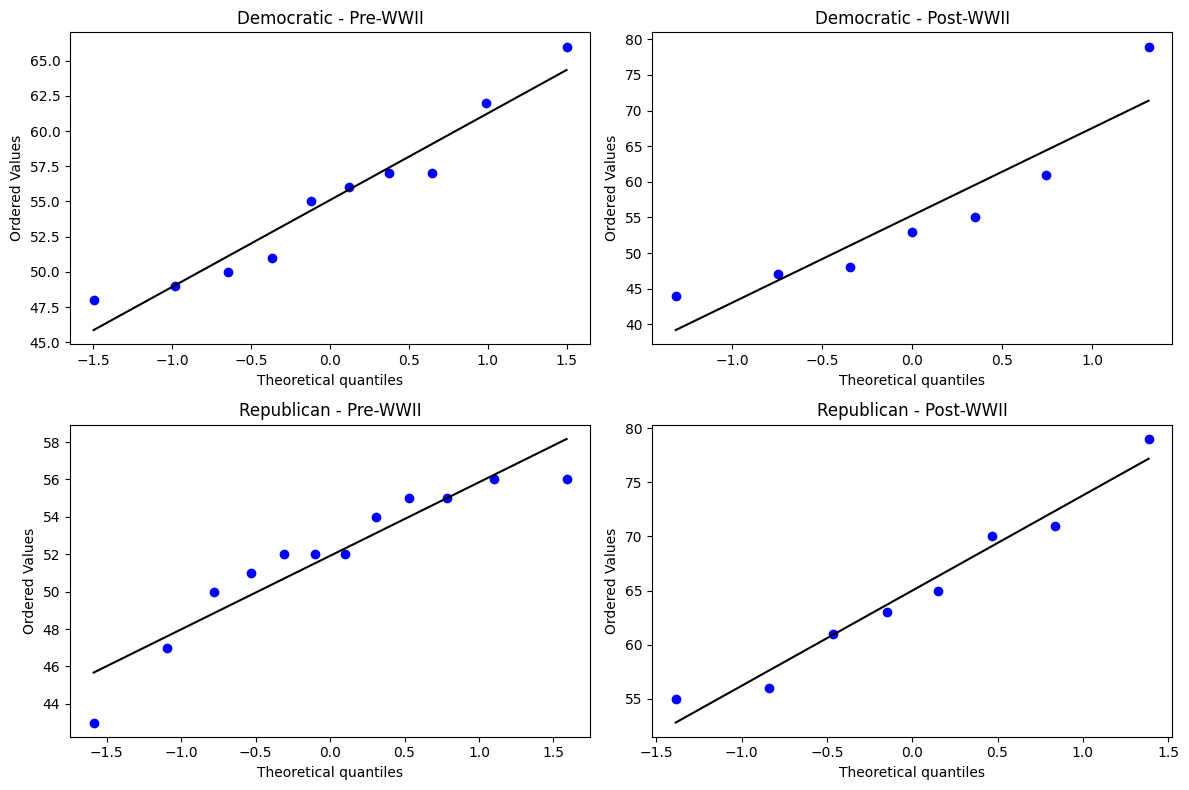

In [15]:
import scipy.stats as stats

# Define all four groups
groups = {
	'Democratic - Pre-WWII': demo_pre,
	'Democratic - Post-WWII': demo_post,
	'Republican - Pre-WWII': rep_pre,
	'Republican - Post-WWII': rep_post
}

# Create Q-Q plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, (label, data) in zip(axs.flatten(), groups.items()):
	stats.probplot(data, dist='norm', plot=ax)
	lines = ax.get_lines()
	lines[0].set_color('blue')
	lines[1].set_color('black')
	ax.set_title(label)

plt.tight_layout()
plt.show()

Each group follows a fairly straight line—so normality is reasonable.

In [16]:
# --- Run Welch's t-tests (unequal variances) ---
from scipy.stats import ttest_ind

t_demo = ttest_ind(demo_pre, demo_post, equal_var=False)
t_rep = ttest_ind(rep_pre, rep_post, equal_var=False)

def detect_significance(p, alpha):
	if p < alpha:
		print('Reject H_0, significant shift in age')
	else:
		print('Fail to reject H_0, no strong evidence')
	print()

# --- Print results ---
print(f'Democratic Age Shift p-value: {t_demo.pvalue:.6f}')
detect_significance(t_demo.pvalue, 0.05)

print(f'Republican Age Shift p-value: {t_rep.pvalue:.6f}')
detect_significance(t_rep.pvalue, 0.05)

Democratic Age Shift p-value: 0.970447
Fail to reject H_0, no strong evidence

Republican Age Shift p-value: 0.002022
Reject H_0, significant shift in age



## 📋 Final Conclusions

Our analysis finds no statistically significant shift in the average inaugural age of __Democratic__ presidents before and after World War II.

However, for __Republican__ presidents, the data reveals a clear and __statistically significant increase__ in average age after WWII—one unlikely caused by chance alone.

#### What might this suggest?

- Republican candidates post-WWII may have leaned more heavily on seniority, experience, and "gravitas."

	With the U.S. emerging as a global superpower, a more seasoned appearance may have projected authority on the international stage.

- The Cold War which followed introduced new anxieties—nuclear tensions and global diplomacy.

	Voters may have found reassurance in older Republican candidates who appeared stable, authoritative, and prepared for such challenges.

- Democratic candidates, by contrast, may have increasingly emphasized youth, energy, and progressive change.

	This aligns with figures like JFK, Clinton, and Obama—each representing generational shifts and campaign messages built around renewal.

- It's also possible voter base demographics played a role.

	If Republican voters skewed older, they may have felt more aligned with—and voted for—candidates who reflected their own stage of life and traditional values, as younger voters aligned more with modern trends.

While our analysis can't claim causation, it does uncover a __real, measurable shift__ in Republican candidate profiles post-WWII.

And this is where data science delivers: surfacing patterns that provoke thoughtful questions—about strategy, identity, and how parties evolve with time.